In [1]:
# !pip install kaggle
# from google.colab import files
# files.upload()

In [2]:
# !ls -1ha kaggle.json

In [3]:
from google.colab import drive

drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# # Permission Warning 이 일어나지 않도록 
# !chmod 600 ~/.kaggle/kaggle.json
# # 본인이 참가한 모든 대회 보기 
# !kaggle competitions list

In [5]:
!pip3 install tokenizers wandb sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.6 MB 14.9 MB/s 
     |████████████████████████████████| 1.8 MB 59.3 MB/s 
     |████████████████████████████████| 1.2 MB 69.1 MB/s 
     |████████████████████████████████| 145 kB 85.3 MB/s 
     |████████████████████████████████| 181 kB 84.2 MB/s 
     |████████████████████████████████| 63 kB 1.9 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=e9318e9d1ec51c375388ebb80f9084428629361e482e4b4c75eeee4b87d69e2b
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


In [6]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 13.9 MB/s 
     |████████████████████████████████| 86 kB 5.8 MB/s 
     |████████████████████████████████| 596 kB 85.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [7]:
import os
os.chdir("drive/")
os.chdir('My Drive')
os.chdir('Kaggle')

In [8]:
# !kaggle competitions download -c us-patent-phrase-to-phrase-matching
# !unzip us-patent-phrase-to-phrase-matching.zip
# !ls

In [9]:
# debert_v3_tokenizer_path = 'deberta-v2-v3-fast-tokenizer'
# %env TOKENIZERS_PARALLELISM=true

# import shutil
# from pathlib import Path

# transformers_path = Path('/usr/local/lib/python3.7/dist-packages/transformers')
# input_dir = Path('./deberta-v2-v3-fast-tokenizer')

# convert_file = input_dir / "convert_slow_tokenizer.py"
# conversion_path = transformers_path / convert_file.name

# if conversion_path.exists():
#     conversion_path.unlink()

# shutil.copy(convert_file, transformers_path)
# deberta_v2_path = transformers_path / "models" / "deberta_v2"

# for filename in ['tokenization_deberta_v2.py', 'tokenization_deberta_v2_fast.py']:
#     filepath = deberta_v2_path/filename
    
#     if filepath.exists():
#         filepath.unlink()
#     shutil.copy(input_dir/filename, filepath)

In [10]:
OUTPUT_DIR = './pppm-albert/'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

In [11]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Jun 14 23:59:51 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [12]:
# ====================================================
# CFG
# ====================================================
class CFG:
    wandb=True
    competition='PPPM'
    _wandb_kernel='bluehills'
    debug=False
    apex=True
    print_freq=100
    num_workers=4
    model="albert-xxlarge-v2"
    scheduler='cosine' # ['linear', 'cosine']
    batch_scheduler=True
    num_cycles=0.5
    num_warmup_steps=50 # [0, 50, 100]
    epochs=5
    encoder_lr=1e-5 #2e-5
    decoder_lr=1e-5 #2e-5
    min_lr=5e-7
    eps=5e-7
    betas=(0.9, 0.999)
    batch_size=10
    fc_dropout=0.15
    target_size=1
    max_len=512
    weight_decay=0.01
    gradient_accumulation_steps=1
    max_grad_norm=1000
    seed=42
    train_all_index=20
    n_fold=5
    trn_fold=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
    train=True
    
if CFG.debug:
    CFG.epochs = 2
    CFG.trn_fold = [0]

In [13]:
# ====================================================
# wandb
# ====================================================
if CFG.wandb:
    import wandb
    try:
        # from kaggle_secrets import UserSecretsClient
        # user_secrets = UserSecretsClient()
        # secret_value_0 = user_secrets.get_secret("wandb_api")
        # wandb.login(key=secret_value_0)
        print('login to wandb')
        wandb.login()
        anony = None
    except:
        anony = "must"
        print('If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as wandb_api. \nGet your W&B access token from here: https://wandb.ai/authorize')


    def class2dict(f):
        return dict((name, getattr(f, name)) for name in dir(f) if not name.startswith('__'))

    run = wandb.init(project='PPPM-MSE', 
                     name=CFG.model,
                     config=class2dict(CFG),
                     group=CFG.model,
                     job_type="train",
                     anonymous=anony)

login to wandb


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: bluehills. Use `wandb login --relogin` to force relogin


# Library

In [14]:
# ====================================================
# Library
# ====================================================
import os
import gc
import re
import ast
import sys
import copy
import json
import time
import math
import shutil
import string
import pickle
import random
import joblib
import itertools
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

import scipy as sp
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from tqdm.auto import tqdm
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedGroupKFold

import torch
print(f"torch.__version__: {torch.__version__}")
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.optim import Adam, SGD, AdamW
from torch.utils.data import DataLoader, Dataset
import torch.cuda.amp as amp

import tokenizers
import transformers
print(f"tokenizers.__version__: {tokenizers.__version__}")
print(f"transformers.__version__: {transformers.__version__}")
from transformers import AutoTokenizer, AutoModel, AutoConfig, AutoModelForSequenceClassification
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
from transformers import AutoTokenizer, AutoConfig, AutoModelForTokenClassification

%env TOKENIZERS_PARALLELISM=true

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch.__version__: 1.11.0+cu113
tokenizers.__version__: 0.12.1
transformers.__version__: 4.19.4
env: TOKENIZERS_PARALLELISM=true


# Utils

In [15]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    score = sp.stats.pearsonr(y_true, y_pred)[0]
    return score


def get_logger(filename=OUTPUT_DIR+'train'):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = get_logger()

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=42)

# Data Loading

In [16]:
# ====================================================
# Data Loading
# ====================================================
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')
print(f"train.shape: {train.shape}")
print(f"test.shape: {test.shape}")
print(f"submission.shape: {submission.shape}")
display(train.head())
display(test.head())
display(submission.head())

train.shape: (36473, 5)
test.shape: (36, 4)
submission.shape: (36, 2)


,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00


,id,anchor,target,context
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02
1,09e418c93a776564,adjust gas flow,altering gas flow,F23
2,36baf228038e314b,lower trunnion,lower locating,B60
3,1f37ead645e7f0c8,cap component,upper portion,D06
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04


,id,score
0,4112d61851461f60,0
1,09e418c93a776564,0
2,36baf228038e314b,0
3,1f37ead645e7f0c8,0
4,71a5b6ad068d531f,0


In [17]:
# ====================================================
# CPC Data
# ====================================================
def get_cpc_texts():
    contexts = []
    pattern = '[A-Z]\d+'
    for file_name in os.listdir('./CPCSchemeXML202105'):
        result = re.findall(pattern, file_name)
        if result:
            contexts.append(result)
    contexts = sorted(set(sum(contexts, [])))
    results = {}
    for cpc in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'Y']:
        with open(f'./CPCTitleList202202/cpc-section-{cpc}_20220201.txt') as f:
            s = f.read()
        pattern = f'{cpc}\t\t.+'
        result = re.findall(pattern, s)
        cpc_result = result[0].lstrip(pattern)
        for context in [c for c in contexts if c[0] == cpc]:
            pattern = f'{context}\t\t.+'
            result = re.findall(pattern, s)
            results[context] = cpc_result + ". " + result[0].lstrip(pattern)
    return results


def get_cpc_texts_nakama():
    contexts = []
    pattern = '[A-Z]\d+'
    for file_name in os.listdir('./CPCSchemeXML202105'):
        result = re.findall(pattern, file_name)
        if result:
            contexts.append(result)
    contexts = sorted(set(sum(contexts, [])))
    results = {}
    for cpc in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'Y']:
        with open(f'./CPCTitleList202202/cpc-section-{cpc}_20220201.txt') as f:
            s = f.read()
        pattern = f'{cpc}\t\t.+'
        result = re.findall(pattern, s)
        cpc_result = result[0].lstrip(pattern)
        for context in [c for c in contexts if c[0] == cpc]:
            pattern = f'{context}\t\t.+'
            result = re.findall(pattern, s)
            results[context] = cpc_result + ". " + result[0].lstrip(pattern)
    return results


cpc_texts = get_cpc_texts()
# cpc_texts = get_cpc_texts_nakama()
torch.save(cpc_texts, OUTPUT_DIR+"cpc_texts.pth")
train['context_text'] = train['context'].map(cpc_texts)
test['context_text'] = test['context'].map(cpc_texts)
display(train.head())
display(test.head())

,id,anchor,target,context,score,context_text
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...


,id,anchor,target,context,context_text
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,PHYSICS. OPTICS
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,MECHANICAL ENGINEERING; LIGHTING; HEATING; WEA...
2,36baf228038e314b,lower trunnion,lower locating,B60,PERFORMING OPERATIONS; TRANSPORTING. VEHICLES ...
3,1f37ead645e7f0c8,cap component,upper portion,D06,TEXTILES; PAPER. TREATMENT OF TEXTILES OR THE ...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE


In [18]:
train['text'] = train['anchor'] + '[SEP]' + train['target'] + '[SEP]'  + train['context_text']
test['text'] = test['anchor'] + '[SEP]' + test['target'] + '[SEP]'  + test['context_text']
display(train.head())
display(test.head())

,id,anchor,target,context,score,context_text,text
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]abatement of pollution[SEP]HUMAN...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]act of abating[SEP]HUMAN NECESSI...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]active catalyst[SEP]HUMAN NECESS...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]eliminating process[SEP]HUMAN NE...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]forest region[SEP]HUMAN NECESSIT...


,id,anchor,target,context,context_text,text
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,PHYSICS. OPTICS,opc drum[SEP]inorganic photoconductor drum[SEP...
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,MECHANICAL ENGINEERING; LIGHTING; HEATING; WEA...,adjust gas flow[SEP]altering gas flow[SEP]MECH...
2,36baf228038e314b,lower trunnion,lower locating,B60,PERFORMING OPERATIONS; TRANSPORTING. VEHICLES ...,lower trunnion[SEP]lower locating[SEP]PERFORMI...
3,1f37ead645e7f0c8,cap component,upper portion,D06,TEXTILES; PAPER. TREATMENT OF TEXTILES OR THE ...,cap component[SEP]upper portion[SEP]TEXTILES; ...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE,neural stimulation[SEP]artificial neural netwo...


# EDA

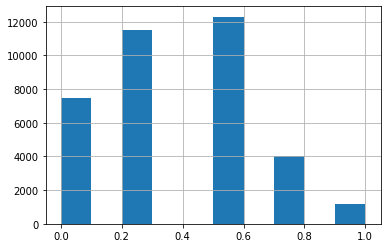

In [19]:
train['score'].hist()

In [20]:
display(train['context'].apply(lambda x: x[0]).value_counts())

B    8019
H    6195
G    6013
C    5288
A    4094
F    4054
E    1531
D    1279
Name: context, dtype: int64

# CV Split

In [21]:
# ====================================================
# CV split
# ====================================================
# train['score_map'] = train['score'].map({0.00: 0, 0.25: 1, 0.50: 2, 0.75: 3, 1.00: 4})
# Fold = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
# for n, (train_index, val_index) in enumerate(Fold.split(train, train['score_map'])):
#     train.loc[val_index, 'fold'] = int(n)
# train['fold'] = train['fold'].astype(int)
# display(train.groupby('fold').size())

In [22]:
# train['score_map'] = train['score'].map({0.00: 0, 0.25: 1, 0.50: 2, 0.75: 3, 1.00: 4})

# encoder = LabelEncoder()
# train['anchor_map'] = encoder.fit_transform(train['anchor'])

# kf = StratifiedGroupKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
# for n, (_, valid_index) in enumerate(kf.split(train, train['score_map'], groups=train['anchor_map'])):
#     train.loc[valid_index, 'fold'] = int(n)

# train['fold'] = train['fold'].astype(int)

In [23]:
# titles = pd.read_csv('./titles.csv')
# train = train.merge(titles, left_on='context', right_on='code')
# train['fold'] = -1
# kf = StratifiedGroupKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)

# for f, (t_, v_) in enumerate(kf.split(X=train, y=train['anchor'], groups=train['anchor'])):
#     train.loc[v_, 'fold'] = f

# train['fold'].hist()
# train['text'] = train['anchor'] + '[SEP]' + train['title'].apply(str.lower)
# train = train[['id','anchor', 'target', 'context', 'score', 'title', 'fold', 'text']]

In [24]:
!pip3 install -q iterative-stratification
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

dfx = pd.get_dummies(train, columns=["score"]).groupby(["anchor"], as_index=False).sum()
cols = [c for c in dfx.columns if c.startswith("score_") or c == "anchor"]
dfx = dfx[cols]

mskf = MultilabelStratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=42)
labels = [c for c in dfx.columns if c != "anchor"]
dfx_labels = dfx[labels]
dfx["fold"] = -1

for fold, (trn_, val_) in enumerate(mskf.split(dfx, dfx_labels)):
    print(len(trn_), len(val_))
    dfx.loc[val_, "fold"] = fold

train = train.merge(dfx[["anchor", "fold"]], on="anchor", how="left")
print(train.fold.value_counts())

587 146
587 146
586 147
586 147
586 147
2    7683
0    7592
3    7324
1    6995
4    6879
Name: fold, dtype: int64


In [25]:
if CFG.debug:
    display(train.groupby('fold').size())
    train = train.sample(n=1000, random_state=0).reset_index(drop=True)
    display(train.groupby('fold').size())

# Tokenizer

In [26]:
# ====================================================
# tokenizer
# ====================================================
tokenizer = AutoTokenizer.from_pretrained(CFG.model)
tokenizer.save_pretrained(OUTPUT_DIR+'tokenizer/')
CFG.tokenizer = tokenizer

Downloading:   0%|          | 0.00/710 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/742k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.25M [00:00<?, ?B/s]

# Dataset

In [27]:
# ====================================================
# Define max_len
# ====================================================
lengths_dict = {}

lengths = []
tk0 = tqdm(cpc_texts.values(), total=len(cpc_texts))
for text in tk0:
    length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
    lengths.append(length)
lengths_dict['context_text'] = lengths

for text_col in ['anchor', 'target']:
    lengths = []
    tk0 = tqdm(train[text_col].fillna("").values, total=len(train))
    for text in tk0:
        length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
        lengths.append(length)
    lengths_dict[text_col] = lengths
    
CFG.max_len = max(lengths_dict['anchor']) + max(lengths_dict['target'])\
                + max(lengths_dict['context_text']) + 4 # CLS + SEP + SEP + SEP
LOGGER.info(f"max_len: {CFG.max_len}")

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/36473 [00:00<?, ?it/s]

  0%|          | 0/36473 [00:00<?, ?it/s]

max_len: 127


In [28]:
# ====================================================
# Dataset
# ====================================================
def prepare_input(cfg, text):
    inputs = cfg.tokenizer(text,
                           add_special_tokens=True,
                           max_length=cfg.max_len,
                           padding="max_length",
                           return_attention_mask=True,
                           return_offsets_mapping=False)
    for k, v in inputs.items():
        inputs[k] = torch.tensor(v, dtype=torch.long)
    return inputs


class TrainDataset(Dataset):
    def __init__(self, cfg, df):
        self.cfg = cfg
        self.texts = df['text'].values
        self.labels = df['score'].values

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, item):
        inputs = prepare_input(self.cfg, self.texts[item])
        label = torch.tensor(self.labels[item], dtype=torch.float)
        return inputs, label

In [29]:
"""
train_dataset = TrainDataset(CFG, train)
inputs, label = train_dataset[0]
print(inputs)
print(label)
"""

'\ntrain_dataset = TrainDataset(CFG, train)\ninputs, label = train_dataset[0]\nprint(inputs)\nprint(label)\n'

# Model

In [30]:
# ====================================================
# Model
# ====================================================
class CustomModel(nn.Module):
    def __init__(self, cfg, config_path=None, pretrained=False):
        super().__init__()
        self.cfg = cfg
        if config_path is None:
            self.config = AutoConfig.from_pretrained(cfg.model, output_hidden_states=True)
        else:
            self.config = torch.load(config_path)
        if pretrained:
            self.model = AutoModel.from_pretrained(cfg.model, config=self.config)
            # self.model = AutoModelForSequenceClassification.from_pretrained(cfg.model, config=self.config)
        else:
            self.model = AutoModel.from_config(self.config)
            # self.model = AutoModelForSequenceClassification.from_config(self.config)
        self.fc_dropout = nn.Dropout(cfg.fc_dropout)
        self.fc = nn.Linear(self.config.hidden_size, self.cfg.target_size)
        self._init_weights(self.fc)
        self.attention = nn.Sequential(
            nn.Linear(self.config.hidden_size, 512),
            nn.Tanh(),
            nn.Linear(512, 1),
            nn.Softmax(dim=1)
        )
        self._init_weights(self.attention)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        
    def feature(self, inputs):
        # outputs = self.model(**inputs)
        outputs = self.model(inputs['input_ids'], inputs['attention_mask'])
        last_hidden_states = outputs[0]
        # feature = torch.mean(last_hidden_states, 1)
        weights = self.attention(last_hidden_states)
        feature = torch.sum(weights * last_hidden_states, dim=1)
        return feature

    def forward(self, inputs):
        feature = self.feature(inputs)
        output = self.fc(self.fc_dropout(feature))
        return output


# Helper Functions

In [31]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device):
    model.train()
    scaler = torch.cuda.amp.GradScaler(enabled=CFG.apex)
    losses = AverageMeter()
    start = end = time.time()
    global_step = 0
    for step, (inputs, labels) in enumerate(train_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.cuda.amp.autocast(enabled=CFG.apex):
            y_preds = model(inputs)


        labels = labels.to(torch.float16)
        # print(y_preds.view(-1, 1).dtype)
        # print(labels.view(-1, 1).dtype)
        # loss = criterion(y_preds.sigmoid().view(-1, 1), labels.view(-1, 1))
        loss = criterion(y_preds.view(-1, 1), labels.view(-1, 1))

        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        # print(loss.dtype)

        
        scaler.scale(loss).backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            global_step += 1
            if CFG.batch_scheduler:
                scheduler.step()
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  'LR: {lr:.8f}  '
                  .format(epoch+1, step, len(train_loader), 
                          remain=timeSince(start, float(step+1)/len(train_loader)),
                          loss=losses,
                          grad_norm=grad_norm,
                          lr=scheduler.get_lr()[0]))
        if CFG.wandb:
            wandb.log({f"[fold{fold}] loss": losses.val,
                       f"[fold{fold}] lr": scheduler.get_lr()[0]})
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    losses = AverageMeter()
    model.eval()
    preds = []
    start = end = time.time()
    for step, (inputs, labels) in enumerate(valid_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.no_grad():
            y_preds = model(inputs)
        labels = labels.to(torch.float16)
        loss = criterion(y_preds.sigmoid().view(-1, 1), labels.view(-1, 1))
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        # preds.append(y_preds.sigmoid().to('cpu').numpy())
        preds.append(y_preds.to('cpu').numpy())

        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(step, len(valid_loader),
                          loss=losses,
                          remain=timeSince(start, float(step+1)/len(valid_loader))))
    predictions = np.concatenate(preds)
    predictions = np.concatenate(predictions)
    return losses.avg, predictions


def inference_fn(test_loader, model, device):
    preds = []
    model.eval()
    model.to(device)
    tk0 = tqdm(test_loader, total=len(test_loader))
    for inputs in tk0:
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        with torch.no_grad():
            y_preds = model(inputs)
        # preds.append(y_preds.sigmoid().to('cpu').numpy())
        preds.append(y_preds.to('cpu').numpy())
    predictions = np.concatenate(preds)
    return predictions

In [32]:
# ====================================================
# train loop
# ====================================================
def train_loop(folds, fold):
    
    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    if fold != CFG.train_all_index:
        train_folds = folds[folds['fold'] != fold].reset_index(drop=True)
    else:
        train_folds = folds
    valid_folds = folds[folds['fold'] == fold].reset_index(drop=True)
    valid_labels = valid_folds['score'].values
    
    train_dataset = TrainDataset(CFG, train_folds)
    valid_dataset = TrainDataset(CFG, valid_folds)

    train_loader = DataLoader(train_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=True,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=False,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

    # ====================================================
    # model & optimizer
    # ====================================================
    model = CustomModel(CFG, config_path=None, pretrained=True)

    torch.save(model.config, OUTPUT_DIR+'config.pth')
    model.to(device)
    
    def get_optimizer_params(model, encoder_lr, decoder_lr, weight_decay=0.0):
        param_optimizer = list(model.named_parameters())
        no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
        optimizer_parameters = [
            {'params': [p for n, p in model.model.named_parameters() if not any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': weight_decay},
            {'params': [p for n, p in model.model.named_parameters() if any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': 0.0},
            {'params': [p for n, p in model.named_parameters() if "model" not in n],
             'lr': decoder_lr, 'weight_decay': 0.0}
        ]
        return optimizer_parameters

    optimizer_parameters = get_optimizer_params(model,
                                                encoder_lr=CFG.encoder_lr, 
                                                decoder_lr=CFG.decoder_lr,
                                                weight_decay=CFG.weight_decay)
    optimizer = AdamW(optimizer_parameters, lr=CFG.encoder_lr, eps=CFG.eps, betas=CFG.betas)
    
    # ====================================================
    # scheduler
    # ====================================================
    def get_scheduler(cfg, optimizer, num_train_steps):
        if cfg.scheduler == 'linear':
            scheduler = get_linear_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps
            )
        elif cfg.scheduler == 'cosine':
            scheduler = get_cosine_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps, num_cycles=cfg.num_cycles
            )
        return scheduler
    
    num_train_steps = int(len(train_folds) / CFG.batch_size * CFG.epochs)
    scheduler = get_scheduler(CFG, optimizer, num_train_steps)

    # ====================================================
    # loop
    # ====================================================
    # criterion = nn.BCEWithLogitsLoss(reduction="mean")
    criterion = nn.MSELoss(reduction="mean")
    # criterion = FocalLossV1().cuda()
    
    best_score = 0.

    for epoch in range(CFG.epochs):

        start_time = time.time()

        # train
        avg_loss = train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # eval
        avg_val_loss, predictions = valid_fn(valid_loader, model, criterion, device)
        
        # scoring
        score = get_score(valid_labels, predictions)

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}')
        if CFG.wandb:
            wandb.log({f"[fold{fold}] epoch": epoch+1, 
                       f"[fold{fold}] avg_train_loss": avg_loss, 
                       f"[fold{fold}] avg_val_loss": avg_val_loss,
                       f"[fold{fold}] score": score})
        
        if best_score < score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save({'model': model.state_dict(),
                        'predictions': predictions},
                        OUTPUT_DIR+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth")
        
        torch.cuda.empty_cache()
        gc.collect()

    try:
        predictions = torch.load(OUTPUT_DIR+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth", 
                                map_location=torch.device('cpu'))['predictions']
        valid_folds['pred'] = predictions
    except:
        valid_folds['pred'] = -1

    torch.cuda.empty_cache()
    gc.collect()
    
    return valid_folds

In [ ]:
if __name__ == '__main__':
    
    def get_result(oof_df):
        labels = oof_df['score'].values
        preds = oof_df['pred'].values
        score = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.4f}')
    
    if CFG.train:
        oof_df = pd.DataFrame()
        for fold in range(CFG.n_fold):
            if fold in CFG.trn_fold:
                _oof_df = train_loop(train, fold)
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== fold: {fold} result ==========")
                get_result(_oof_df)
        oof_df = oof_df.reset_index(drop=True)
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        oof_df.to_pickle(OUTPUT_DIR+'oof_df.pkl')
        
    if CFG.wandb:
        wandb.finish()

========== fold: 0 training ==========


Downloading:   0%|          | 0.00/851M [00:00<?, ?B/s]

Some weights of the model checkpoint at albert-xxlarge-v2 were not used when initializing AlbertModel: ['predictions.decoder.weight', 'predictions.LayerNorm.bias', 'predictions.LayerNorm.weight', 'predictions.bias', 'predictions.decoder.bias', 'predictions.dense.bias', 'predictions.dense.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: [1][0/2888] Elapsed 0m 0s (remain 38m 58s) Loss: 0.2566(0.2566) Grad: nan  LR: 0.00000020  
Epoch: [1][100/2888] Elapsed 0m 35s (remain 16m 29s) Loss: 0.0715(0.1194) Grad: 43862.6719  LR: 0.00001000  
Epoch: [1][200/2888] Elapsed 1m 11s (remain 15m 50s) Loss: 0.0395(0.0879) Grad: 24571.6328  LR: 0.00001000  
Epoch: [1][300/2888] Elapsed 1m 46s (remain 15m 14s) Loss: 0.0605(0.0735) Grad: 38164.4883  LR: 0.00000999  
Epoch: [1][400/2888] Elapsed 2m 21s (remain 14m 38s) Loss: 0.0938(0.0653) Grad: 100423.8047  LR: 0.00000999  
Epoch: [1][500/2888] Elapsed 2m 56s (remain 14m 3s) Loss: 0.0258(0.0602) Grad: 19921.2715  LR: 0.00000998  
Epoch: [1][600/2888] Elapsed 3m 32s (remain 13m 27s) Loss: 0.0137(0.0562) Grad: 16327.1104  LR: 0.00000996  
Epoch: [1][700/2888] Elapsed 4m 7s (remain 12m 52s) Loss: 0.0412(0.0527) Grad: 17782.1387  LR: 0.00000995  
Epoch: [1][800/2888] Elapsed 4m 42s (remain 12m 16s) Loss: 0.0485(0.0501) Grad: 27808.9551  LR: 0.00000993  
Epoch: [1][900/2888] Elapsed 5

Epoch 1 - avg_train_loss: 0.0320  avg_val_loss: 0.0989  time: 1366s
Epoch 1 - Score: 0.7930
Epoch 1 - Save Best Score: 0.7930 Model


EVAL: [759/760] Elapsed 5m 46s (remain 0m 0s) Loss: 0.0121(0.0989) 
Epoch: [2][0/2888] Elapsed 0m 0s (remain 26m 35s) Loss: 0.0156(0.0156) Grad: nan  LR: 0.00000907  
Epoch: [2][100/2888] Elapsed 0m 35s (remain 16m 26s) Loss: 0.0111(0.0156) Grad: 25483.5234  LR: 0.00000901  
Epoch: [2][200/2888] Elapsed 1m 11s (remain 15m 49s) Loss: 0.0178(0.0163) Grad: 20942.8984  LR: 0.00000894  
Epoch: [2][300/2888] Elapsed 1m 46s (remain 15m 13s) Loss: 0.0179(0.0161) Grad: 21077.1309  LR: 0.00000887  
Epoch: [2][400/2888] Elapsed 2m 21s (remain 14m 38s) Loss: 0.0242(0.0162) Grad: 25712.9102  LR: 0.00000880  
Epoch: [2][500/2888] Elapsed 2m 56s (remain 14m 2s) Loss: 0.0108(0.0157) Grad: 28383.5332  LR: 0.00000873  
Epoch: [2][600/2888] Elapsed 3m 32s (remain 13m 27s) Loss: 0.0412(0.0159) Grad: 48172.2695  LR: 0.00000866  
Epoch: [2][700/2888] Elapsed 4m 7s (remain 12m 51s) Loss: 0.0091(0.0160) Grad: 18741.2637  LR: 0.00000858  
Epoch: [2][800/2888] Elapsed 4m 42s (remain 12m 16s) Loss: 0.0072(0.0159

Epoch 2 - avg_train_loss: 0.0156  avg_val_loss: 0.0992  time: 1365s
Epoch 2 - Score: 0.8023
Epoch 2 - Save Best Score: 0.8023 Model


EVAL: [759/760] Elapsed 5m 46s (remain 0m 0s) Loss: 0.0110(0.0992) 
Epoch: [3][0/2888] Elapsed 0m 0s (remain 25m 3s) Loss: 0.0086(0.0086) Grad: nan  LR: 0.00000658  
Epoch: [3][100/2888] Elapsed 0m 35s (remain 16m 26s) Loss: 0.0103(0.0098) Grad: 24857.2363  LR: 0.00000647  
Epoch: [3][200/2888] Elapsed 1m 10s (remain 15m 48s) Loss: 0.0101(0.0099) Grad: 13867.7549  LR: 0.00000637  
Epoch: [3][300/2888] Elapsed 1m 46s (remain 15m 13s) Loss: 0.0099(0.0096) Grad: 11622.0820  LR: 0.00000626  
Epoch: [3][400/2888] Elapsed 2m 21s (remain 14m 37s) Loss: 0.0113(0.0096) Grad: 17783.5215  LR: 0.00000616  
Epoch: [3][500/2888] Elapsed 2m 56s (remain 14m 2s) Loss: 0.0088(0.0099) Grad: 18132.7598  LR: 0.00000605  
Epoch: [3][600/2888] Elapsed 3m 32s (remain 13m 26s) Loss: 0.0069(0.0099) Grad: 11874.2109  LR: 0.00000594  
Epoch: [3][700/2888] Elapsed 4m 7s (remain 12m 51s) Loss: 0.0049(0.0098) Grad: 10679.9873  LR: 0.00000583  
Epoch: [3][800/2888] Elapsed 4m 42s (remain 12m 16s) Loss: 0.0153(0.0097)

Epoch 3 - avg_train_loss: 0.0095  avg_val_loss: 0.0982  time: 1365s
Epoch 3 - Score: 0.8011


EVAL: [759/760] Elapsed 5m 46s (remain 0m 0s) Loss: 0.0126(0.0982) 
Epoch: [4][0/2888] Elapsed 0m 0s (remain 26m 3s) Loss: 0.0021(0.0021) Grad: nan  LR: 0.00000347  
Epoch: [4][100/2888] Elapsed 0m 35s (remain 16m 26s) Loss: 0.0048(0.0054) Grad: 14980.1416  LR: 0.00000337  
Epoch: [4][200/2888] Elapsed 1m 10s (remain 15m 48s) Loss: 0.0036(0.0055) Grad: 11577.7305  LR: 0.00000327  
Epoch: [4][300/2888] Elapsed 1m 46s (remain 15m 12s) Loss: 0.0031(0.0058) Grad: 8514.8350  LR: 0.00000317  
Epoch: [4][400/2888] Elapsed 2m 21s (remain 14m 37s) Loss: 0.0058(0.0057) Grad: 16609.4258  LR: 0.00000307  
Epoch: [4][500/2888] Elapsed 2m 56s (remain 14m 1s) Loss: 0.0082(0.0057) Grad: 29446.2207  LR: 0.00000296  
Epoch: [4][600/2888] Elapsed 3m 31s (remain 13m 26s) Loss: 0.0050(0.0056) Grad: 15363.3125  LR: 0.00000287  
Epoch: [4][700/2888] Elapsed 4m 7s (remain 12m 51s) Loss: 0.0028(0.0056) Grad: 12409.2178  LR: 0.00000277  
Epoch: [4][800/2888] Elapsed 4m 42s (remain 12m 15s) Loss: 0.0101(0.0056) 

Epoch 4 - avg_train_loss: 0.0053  avg_val_loss: 0.0975  time: 1365s
Epoch 4 - Score: 0.8014


EVAL: [759/760] Elapsed 5m 46s (remain 0m 0s) Loss: 0.0114(0.0975) 
Epoch: [5][0/2888] Elapsed 0m 0s (remain 25m 34s) Loss: 0.0044(0.0044) Grad: nan  LR: 0.00000096  
Epoch: [5][100/2888] Elapsed 0m 35s (remain 16m 25s) Loss: 0.0002(0.0034) Grad: 3641.3257  LR: 0.00000090  
Epoch: [5][200/2888] Elapsed 1m 10s (remain 15m 48s) Loss: 0.0014(0.0035) Grad: 6770.4185  LR: 0.00000084  
Epoch: [5][300/2888] Elapsed 1m 46s (remain 15m 12s) Loss: 0.0017(0.0035) Grad: 7728.1821  LR: 0.00000078  
Epoch: [5][400/2888] Elapsed 2m 21s (remain 14m 36s) Loss: 0.0275(0.0034) Grad: 25999.0410  LR: 0.00000072  
Epoch: [5][500/2888] Elapsed 2m 56s (remain 14m 1s) Loss: 0.0108(0.0033) Grad: 20551.9316  LR: 0.00000066  
Epoch: [5][600/2888] Elapsed 3m 31s (remain 13m 26s) Loss: 0.0022(0.0032) Grad: 12762.9385  LR: 0.00000061  
Epoch: [5][700/2888] Elapsed 4m 7s (remain 12m 50s) Loss: 0.0019(0.0034) Grad: 8240.9609  LR: 0.00000056  
Epoch: [5][800/2888] Elapsed 4m 42s (remain 12m 15s) Loss: 0.0009(0.0033) Gr

Epoch 5 - avg_train_loss: 0.0032  avg_val_loss: 0.0974  time: 1364s
Epoch 5 - Score: 0.7984


EVAL: [759/760] Elapsed 5m 46s (remain 0m 0s) Loss: 0.0119(0.0974) 


========== fold: 0 result ==========
Score: 0.8023
========== fold: 1 training ==========
Some weights of the model checkpoint at albert-xxlarge-v2 were not used when initializing AlbertModel: ['predictions.decoder.weight', 'predictions.LayerNorm.bias', 'predictions.LayerNorm.weight', 'predictions.bias', 'predictions.decoder.bias', 'predictions.dense.bias', 'predictions.dense.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: [1][0/2947] Elapsed 0m 0s (remain 28m 17s) Loss: 0.0627(0.0627) Grad: nan  LR: 0.00000020  
Epoch: [1][100/2947] Elapsed 0m 35s (remain 16m 48s) Loss: 0.0797(0.0704) Grad: 69743.2500  LR: 0.00001000  
Epoch: [1][200/2947] Elapsed 1m 11s (remain 16m 10s) Loss: 0.0690(0.0638) Grad: 100068.8672  LR: 0.00001000  
Epoch: [1][300/2947] Elapsed 1m 46s (remain 15m 34s) Loss: 0.0324(0.0592) Grad: 47135.1953  LR: 0.00000999  
Epoch: [1][400/2947] Elapsed 2m 21s (remain 14m 58s) Loss: 0.0325(0.0554) Grad: 26453.3066  LR: 0.00000999  
Epoch: [1][500/2947] Elapsed 2m 56s (remain 14m 23s) Loss: 0.0306(0.0531) Grad: 53434.0977  LR: 0.00000998  
Epoch: [1][600/2947] Elapsed 3m 32s (remain 13m 47s) Loss: 0.0507(0.0515) Grad: 86632.7969  LR: 0.00000997  
Epoch: [1][700/2947] Elapsed 4m 7s (remain 13m 12s) Loss: 0.0448(0.0495) Grad: 84884.6016  LR: 0.00000995  
Epoch: [1][800/2947] Elapsed 4m 42s (remain 12m 37s) Loss: 0.0557(0.0475) Grad: 54384.0039  LR: 0.00000994  
Epoch: [1][900/2947] Elapsed 

Epoch 1 - avg_train_loss: 0.0323  avg_val_loss: 0.0942  time: 1358s
Epoch 1 - Score: 0.8013
Epoch 1 - Save Best Score: 0.8013 Model


EVAL: [699/700] Elapsed 5m 18s (remain 0m 0s) Loss: 0.0287(0.0942) 
Epoch: [2][0/2947] Elapsed 0m 0s (remain 26m 31s) Loss: 0.0163(0.0163) Grad: nan  LR: 0.00000907  
Epoch: [2][100/2947] Elapsed 0m 35s (remain 16m 45s) Loss: 0.0080(0.0179) Grad: 38847.0000  LR: 0.00000901  
Epoch: [2][200/2947] Elapsed 1m 10s (remain 16m 8s) Loss: 0.0083(0.0176) Grad: 23581.7402  LR: 0.00000894  
Epoch: [2][300/2947] Elapsed 1m 46s (remain 15m 33s) Loss: 0.0313(0.0182) Grad: 46666.4531  LR: 0.00000888  
Epoch: [2][400/2947] Elapsed 2m 21s (remain 14m 57s) Loss: 0.0116(0.0178) Grad: 15742.8506  LR: 0.00000881  
Epoch: [2][500/2947] Elapsed 2m 56s (remain 14m 22s) Loss: 0.0153(0.0178) Grad: 22821.7988  LR: 0.00000874  
Epoch: [2][600/2947] Elapsed 3m 31s (remain 13m 46s) Loss: 0.0219(0.0176) Grad: 31445.5742  LR: 0.00000866  
Epoch: [2][700/2947] Elapsed 4m 7s (remain 13m 11s) Loss: 0.0042(0.0174) Grad: 15109.6055  LR: 0.00000859  
Epoch: [2][800/2947] Elapsed 4m 42s (remain 12m 36s) Loss: 0.0163(0.0172

Epoch 2 - avg_train_loss: 0.0168  avg_val_loss: 0.0992  time: 1357s
Epoch 2 - Score: 0.8163
Epoch 2 - Save Best Score: 0.8163 Model


EVAL: [699/700] Elapsed 5m 18s (remain 0m 0s) Loss: 0.0239(0.0992) 
Epoch: [3][0/2947] Elapsed 0m 0s (remain 26m 30s) Loss: 0.0022(0.0022) Grad: nan  LR: 0.00000658  
Epoch: [3][100/2947] Elapsed 0m 35s (remain 16m 46s) Loss: 0.0053(0.0099) Grad: 13785.7910  LR: 0.00000647  
Epoch: [3][200/2947] Elapsed 1m 10s (remain 16m 8s) Loss: 0.0315(0.0102) Grad: 45655.7852  LR: 0.00000637  
Epoch: [3][300/2947] Elapsed 1m 46s (remain 15m 32s) Loss: 0.0044(0.0102) Grad: 10675.5996  LR: 0.00000627  
Epoch: [3][400/2947] Elapsed 2m 21s (remain 14m 57s) Loss: 0.0105(0.0104) Grad: 20135.6172  LR: 0.00000616  
Epoch: [3][500/2947] Elapsed 2m 56s (remain 14m 21s) Loss: 0.0125(0.0103) Grad: 18640.4043  LR: 0.00000606  
Epoch: [3][600/2947] Elapsed 3m 31s (remain 13m 46s) Loss: 0.0124(0.0102) Grad: 18206.1758  LR: 0.00000596  
Epoch: [3][700/2947] Elapsed 4m 6s (remain 13m 11s) Loss: 0.0174(0.0103) Grad: 24351.5234  LR: 0.00000585  
Epoch: [3][800/2947] Elapsed 4m 42s (remain 12m 36s) Loss: 0.0042(0.0103

Epoch 3 - avg_train_loss: 0.0097  avg_val_loss: 0.0972  time: 1357s
Epoch 3 - Score: 0.8066


EVAL: [699/700] Elapsed 5m 18s (remain 0m 0s) Loss: 0.0284(0.0972) 
Epoch: [4][0/2947] Elapsed 0m 0s (remain 26m 35s) Loss: 0.0015(0.0015) Grad: nan  LR: 0.00000348  
Epoch: [4][100/2947] Elapsed 0m 35s (remain 16m 46s) Loss: 0.0012(0.0054) Grad: 5347.9321  LR: 0.00000338  
Epoch: [4][200/2947] Elapsed 1m 10s (remain 16m 8s) Loss: 0.0074(0.0058) Grad: 10937.0205  LR: 0.00000327  
Epoch: [4][300/2947] Elapsed 1m 46s (remain 15m 32s) Loss: 0.0083(0.0055) Grad: 20673.7832  LR: 0.00000317  
Epoch: [4][400/2947] Elapsed 2m 21s (remain 14m 56s) Loss: 0.0016(0.0054) Grad: 6365.6465  LR: 0.00000308  
Epoch: [4][500/2947] Elapsed 2m 56s (remain 14m 21s) Loss: 0.0046(0.0056) Grad: 14659.2217  LR: 0.00000298  
Epoch: [4][600/2947] Elapsed 3m 31s (remain 13m 46s) Loss: 0.0081(0.0055) Grad: 15995.9502  LR: 0.00000288  
Epoch: [4][700/2947] Elapsed 4m 6s (remain 13m 11s) Loss: 0.0091(0.0055) Grad: 17747.7285  LR: 0.00000278  
Epoch: [4][800/2947] Elapsed 4m 42s (remain 12m 35s) Loss: 0.0005(0.0055) 

Epoch 4 - avg_train_loss: 0.0054  avg_val_loss: 0.0971  time: 1357s
Epoch 4 - Score: 0.8049


EVAL: [699/700] Elapsed 5m 18s (remain 0m 0s) Loss: 0.0269(0.0971) 
Epoch: [5][0/2947] Elapsed 0m 0s (remain 26m 38s) Loss: 0.0078(0.0078) Grad: nan  LR: 0.00000096  
Epoch: [5][100/2947] Elapsed 0m 35s (remain 16m 46s) Loss: 0.0106(0.0032) Grad: 15890.9404  LR: 0.00000090  
Epoch: [5][200/2947] Elapsed 1m 10s (remain 16m 8s) Loss: 0.0009(0.0034) Grad: 6089.7124  LR: 0.00000084  
Epoch: [5][300/2947] Elapsed 1m 46s (remain 15m 32s) Loss: 0.0029(0.0036) Grad: 10762.1914  LR: 0.00000078  
Epoch: [5][400/2947] Elapsed 2m 21s (remain 14m 57s) Loss: 0.0024(0.0035) Grad: 12365.3838  LR: 0.00000073  
Epoch: [5][500/2947] Elapsed 2m 56s (remain 14m 21s) Loss: 0.0021(0.0035) Grad: 10732.7539  LR: 0.00000067  
Epoch: [5][600/2947] Elapsed 3m 31s (remain 13m 46s) Loss: 0.0025(0.0034) Grad: 10406.4004  LR: 0.00000062  
Epoch: [5][700/2947] Elapsed 4m 6s (remain 13m 10s) Loss: 0.0005(0.0033) Grad: 2973.9856  LR: 0.00000057  
Epoch: [5][800/2947] Elapsed 4m 42s (remain 12m 35s) Loss: 0.0034(0.0033) 

Epoch 5 - avg_train_loss: 0.0033  avg_val_loss: 0.0969  time: 1357s
Epoch 5 - Score: 0.8004


EVAL: [699/700] Elapsed 5m 19s (remain 0m 0s) Loss: 0.0266(0.0969) 


========== fold: 1 result ==========
Score: 0.8163
========== fold: 2 training ==========
Some weights of the model checkpoint at albert-xxlarge-v2 were not used when initializing AlbertModel: ['predictions.decoder.weight', 'predictions.LayerNorm.bias', 'predictions.LayerNorm.weight', 'predictions.bias', 'predictions.decoder.bias', 'predictions.dense.bias', 'predictions.dense.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: [1][0/2879] Elapsed 0m 0s (remain 26m 58s) Loss: 0.1447(0.1447) Grad: nan  LR: 0.00000020  
Epoch: [1][100/2879] Elapsed 0m 35s (remain 16m 23s) Loss: 0.0133(0.0899) Grad: 25242.5352  LR: 0.00001000  
Epoch: [1][200/2879] Elapsed 1m 11s (remain 15m 46s) Loss: 0.0459(0.0751) Grad: 70928.5938  LR: 0.00001000  
Epoch: [1][300/2879] Elapsed 1m 46s (remain 15m 10s) Loss: 0.0734(0.0684) Grad: 109074.7891  LR: 0.00000999  
Epoch: [1][400/2879] Elapsed 2m 21s (remain 14m 34s) Loss: 0.0257(0.0630) Grad: 39614.2422  LR: 0.00000999  
Epoch: [1][500/2879] Elapsed 2m 56s (remain 13m 59s) Loss: 0.0223(0.0596) Grad: 58749.8125  LR: 0.00000998  
Epoch: [1][600/2879] Elapsed 3m 32s (remain 13m 23s) Loss: 0.0356(0.0566) Grad: 76847.2656  LR: 0.00000996  
Epoch: [1][700/2879] Elapsed 4m 7s (remain 12m 48s) Loss: 0.0617(0.0544) Grad: 47118.8555  LR: 0.00000995  
Epoch: [1][800/2879] Elapsed 4m 42s (remain 12m 13s) Loss: 0.0407(0.0525) Grad: 49900.2266  LR: 0.00000993  
Epoch: [1][900/2879] Elapsed 

Epoch 1 - avg_train_loss: 0.0346  avg_val_loss: 0.0941  time: 1366s
Epoch 1 - Score: 0.8023
Epoch 1 - Save Best Score: 0.8023 Model


EVAL: [768/769] Elapsed 5m 50s (remain 0m 0s) Loss: 0.0612(0.0941) 
Epoch: [2][0/2879] Elapsed 0m 0s (remain 26m 9s) Loss: 0.0669(0.0669) Grad: nan  LR: 0.00000907  
Epoch: [2][100/2879] Elapsed 0m 35s (remain 16m 22s) Loss: 0.0094(0.0199) Grad: 15123.6416  LR: 0.00000901  
Epoch: [2][200/2879] Elapsed 1m 10s (remain 15m 45s) Loss: 0.0120(0.0190) Grad: 15518.1758  LR: 0.00000894  
Epoch: [2][300/2879] Elapsed 1m 46s (remain 15m 9s) Loss: 0.0160(0.0186) Grad: 18911.3613  LR: 0.00000887  
Epoch: [2][400/2879] Elapsed 2m 21s (remain 14m 33s) Loss: 0.0309(0.0187) Grad: 24875.5723  LR: 0.00000880  
Epoch: [2][500/2879] Elapsed 2m 56s (remain 13m 58s) Loss: 0.0129(0.0184) Grad: 31308.6445  LR: 0.00000873  
Epoch: [2][600/2879] Elapsed 3m 31s (remain 13m 23s) Loss: 0.0312(0.0183) Grad: 60808.9883  LR: 0.00000865  
Epoch: [2][700/2879] Elapsed 4m 7s (remain 12m 47s) Loss: 0.0067(0.0183) Grad: 15552.3818  LR: 0.00000858  
Epoch: [2][800/2879] Elapsed 4m 42s (remain 12m 12s) Loss: 0.0295(0.0182)

Epoch 2 - avg_train_loss: 0.0172  avg_val_loss: 0.0977  time: 1365s
Epoch 2 - Score: 0.8163
Epoch 2 - Save Best Score: 0.8163 Model


EVAL: [768/769] Elapsed 5m 50s (remain 0m 0s) Loss: 0.0595(0.0977) 
Epoch: [3][0/2879] Elapsed 0m 0s (remain 26m 8s) Loss: 0.0089(0.0089) Grad: nan  LR: 0.00000658  
Epoch: [3][100/2879] Elapsed 0m 35s (remain 16m 21s) Loss: 0.0079(0.0098) Grad: 18459.5664  LR: 0.00000647  
Epoch: [3][200/2879] Elapsed 1m 10s (remain 15m 44s) Loss: 0.0069(0.0102) Grad: 15810.6631  LR: 0.00000637  
Epoch: [3][300/2879] Elapsed 1m 46s (remain 15m 8s) Loss: 0.0114(0.0104) Grad: 16576.9531  LR: 0.00000626  
Epoch: [3][400/2879] Elapsed 2m 21s (remain 14m 33s) Loss: 0.0235(0.0107) Grad: 29431.2285  LR: 0.00000615  
Epoch: [3][500/2879] Elapsed 2m 56s (remain 13m 57s) Loss: 0.0153(0.0107) Grad: 25814.2812  LR: 0.00000605  
Epoch: [3][600/2879] Elapsed 3m 31s (remain 13m 22s) Loss: 0.0090(0.0108) Grad: 13151.7891  LR: 0.00000594  
Epoch: [3][700/2879] Elapsed 4m 6s (remain 12m 47s) Loss: 0.0144(0.0107) Grad: 16225.9668  LR: 0.00000583  
Epoch: [3][800/2879] Elapsed 4m 42s (remain 12m 12s) Loss: 0.0177(0.0106)

Epoch 3 - avg_train_loss: 0.0099  avg_val_loss: 0.0970  time: 1365s
Epoch 3 - Score: 0.8201
Epoch 3 - Save Best Score: 0.8201 Model


EVAL: [768/769] Elapsed 5m 50s (remain 0m 0s) Loss: 0.0572(0.0970) 
Epoch: [4][0/2879] Elapsed 0m 0s (remain 25m 59s) Loss: 0.0068(0.0068) Grad: nan  LR: 0.00000347  
Epoch: [4][100/2879] Elapsed 0m 35s (remain 16m 22s) Loss: 0.0051(0.0054) Grad: 13559.8086  LR: 0.00000337  
Epoch: [4][200/2879] Elapsed 1m 10s (remain 15m 44s) Loss: 0.0117(0.0053) Grad: 27840.4004  LR: 0.00000327  
Epoch: [4][300/2879] Elapsed 1m 46s (remain 15m 8s) Loss: 0.0036(0.0056) Grad: 9016.3477  LR: 0.00000317  
Epoch: [4][400/2879] Elapsed 2m 21s (remain 14m 33s) Loss: 0.0011(0.0057) Grad: 5474.8247  LR: 0.00000306  
Epoch: [4][500/2879] Elapsed 2m 56s (remain 13m 57s) Loss: 0.0032(0.0057) Grad: 12841.1240  LR: 0.00000296  
Epoch: [4][600/2879] Elapsed 3m 31s (remain 13m 22s) Loss: 0.0025(0.0056) Grad: 9568.4502  LR: 0.00000286  
Epoch: [4][700/2879] Elapsed 4m 6s (remain 12m 47s) Loss: 0.0056(0.0056) Grad: 13166.0830  LR: 0.00000277  
Epoch: [4][800/2879] Elapsed 4m 42s (remain 12m 12s) Loss: 0.0027(0.0057) G

Epoch 4 - avg_train_loss: 0.0054  avg_val_loss: 0.0953  time: 1364s
Epoch 4 - Score: 0.8168


EVAL: [768/769] Elapsed 5m 50s (remain 0m 0s) Loss: 0.0602(0.0953) 
Epoch: [5][0/2879] Elapsed 0m 0s (remain 25m 55s) Loss: 0.0014(0.0014) Grad: nan  LR: 0.00000096  
Epoch: [5][100/2879] Elapsed 0m 35s (remain 16m 21s) Loss: 0.0022(0.0035) Grad: 10329.2979  LR: 0.00000090  
Epoch: [5][200/2879] Elapsed 1m 10s (remain 15m 44s) Loss: 0.0027(0.0033) Grad: 9599.5830  LR: 0.00000084  
Epoch: [5][300/2879] Elapsed 1m 46s (remain 15m 8s) Loss: 0.0006(0.0031) Grad: 4894.0098  LR: 0.00000078  
Epoch: [5][400/2879] Elapsed 2m 21s (remain 14m 32s) Loss: 0.0016(0.0031) Grad: 9414.0371  LR: 0.00000072  
Epoch: [5][500/2879] Elapsed 2m 56s (remain 13m 57s) Loss: 0.0014(0.0031) Grad: 8694.1436  LR: 0.00000066  
Epoch: [5][600/2879] Elapsed 3m 31s (remain 13m 22s) Loss: 0.0037(0.0030) Grad: 12352.6084  LR: 0.00000061  
Epoch: [5][700/2879] Elapsed 4m 6s (remain 12m 46s) Loss: 0.0014(0.0029) Grad: 11814.8477  LR: 0.00000056  
Epoch: [5][800/2879] Elapsed 4m 42s (remain 12m 11s) Loss: 0.0070(0.0029) Gr

Epoch 5 - avg_train_loss: 0.0030  avg_val_loss: 0.0956  time: 1364s
Epoch 5 - Score: 0.8134


EVAL: [768/769] Elapsed 5m 50s (remain 0m 0s) Loss: 0.0578(0.0956) 


========== fold: 2 result ==========
Score: 0.8201
========== fold: 3 training ==========
Some weights of the model checkpoint at albert-xxlarge-v2 were not used when initializing AlbertModel: ['predictions.decoder.weight', 'predictions.LayerNorm.bias', 'predictions.LayerNorm.weight', 'predictions.bias', 'predictions.decoder.bias', 'predictions.dense.bias', 'predictions.dense.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: [1][0/2914] Elapsed 0m 0s (remain 26m 38s) Loss: 0.1681(0.1681) Grad: nan  LR: 0.00000020  
Epoch: [1][100/2914] Elapsed 0m 35s (remain 16m 34s) Loss: 0.0771(0.0813) Grad: 62528.7031  LR: 0.00001000  
Epoch: [1][200/2914] Elapsed 1m 10s (remain 15m 57s) Loss: 0.0296(0.0714) Grad: 61262.1367  LR: 0.00001000  
Epoch: [1][300/2914] Elapsed 1m 46s (remain 15m 21s) Loss: 0.0283(0.0645) Grad: 42768.3047  LR: 0.00000999  
Epoch: [1][400/2914] Elapsed 2m 21s (remain 14m 46s) Loss: 0.0260(0.0585) Grad: 30196.2832  LR: 0.00000999  
Epoch: [1][500/2914] Elapsed 2m 56s (remain 14m 10s) Loss: 0.0266(0.0553) Grad: 31387.7637  LR: 0.00000998  
Epoch: [1][600/2914] Elapsed 3m 31s (remain 13m 35s) Loss: 0.0199(0.0522) Grad: 53089.5352  LR: 0.00000996  
Epoch: [1][700/2914] Elapsed 4m 7s (remain 13m 0s) Loss: 0.0443(0.0502) Grad: 93886.2891  LR: 0.00000995  
Epoch: [1][800/2914] Elapsed 4m 42s (remain 12m 25s) Loss: 0.0261(0.0482) Grad: 42534.6836  LR: 0.00000993  
Epoch: [1][900/2914] Elapsed 5m

Epoch 1 - avg_train_loss: 0.0323  avg_val_loss: 0.0969  time: 1361s
Epoch 1 - Score: 0.8048
Epoch 1 - Save Best Score: 0.8048 Model


EVAL: [732/733] Elapsed 5m 33s (remain 0m 0s) Loss: 0.0186(0.0969) 
Epoch: [2][0/2914] Elapsed 0m 0s (remain 26m 25s) Loss: 0.0074(0.0074) Grad: nan  LR: 0.00000907  
Epoch: [2][100/2914] Elapsed 0m 35s (remain 16m 35s) Loss: 0.0304(0.0184) Grad: 28506.2500  LR: 0.00000901  
Epoch: [2][200/2914] Elapsed 1m 10s (remain 15m 57s) Loss: 0.0223(0.0173) Grad: 35712.9258  LR: 0.00000894  
Epoch: [2][300/2914] Elapsed 1m 46s (remain 15m 21s) Loss: 0.0315(0.0176) Grad: 40343.3281  LR: 0.00000887  
Epoch: [2][400/2914] Elapsed 2m 21s (remain 14m 45s) Loss: 0.0119(0.0172) Grad: 12023.6973  LR: 0.00000880  
Epoch: [2][500/2914] Elapsed 2m 56s (remain 14m 10s) Loss: 0.0095(0.0171) Grad: 13758.9678  LR: 0.00000873  
Epoch: [2][600/2914] Elapsed 3m 31s (remain 13m 35s) Loss: 0.0081(0.0168) Grad: 18180.1582  LR: 0.00000866  
Epoch: [2][700/2914] Elapsed 4m 7s (remain 12m 59s) Loss: 0.0126(0.0169) Grad: 17349.6934  LR: 0.00000859  
Epoch: [2][800/2914] Elapsed 4m 42s (remain 12m 24s) Loss: 0.0118(0.016

Epoch 2 - avg_train_loss: 0.0171  avg_val_loss: 0.0951  time: 1360s
Epoch 2 - Score: 0.8232
Epoch 2 - Save Best Score: 0.8232 Model


EVAL: [732/733] Elapsed 5m 33s (remain 0m 0s) Loss: 0.0151(0.0951) 
Epoch: [3][0/2914] Elapsed 0m 0s (remain 25m 40s) Loss: 0.0011(0.0011) Grad: nan  LR: 0.00000658  
Epoch: [3][100/2914] Elapsed 0m 35s (remain 16m 34s) Loss: 0.0027(0.0097) Grad: 8723.4160  LR: 0.00000647  
Epoch: [3][200/2914] Elapsed 1m 10s (remain 15m 57s) Loss: 0.0153(0.0098) Grad: 20426.7383  LR: 0.00000637  
Epoch: [3][300/2914] Elapsed 1m 46s (remain 15m 21s) Loss: 0.0085(0.0098) Grad: 17163.0938  LR: 0.00000627  
Epoch: [3][400/2914] Elapsed 2m 21s (remain 14m 45s) Loss: 0.0095(0.0096) Grad: 18221.4336  LR: 0.00000616  
Epoch: [3][500/2914] Elapsed 2m 56s (remain 14m 9s) Loss: 0.0106(0.0095) Grad: 10233.8887  LR: 0.00000606  
Epoch: [3][600/2914] Elapsed 3m 31s (remain 13m 34s) Loss: 0.0082(0.0093) Grad: 12658.6289  LR: 0.00000595  
Epoch: [3][700/2914] Elapsed 4m 6s (remain 12m 59s) Loss: 0.0077(0.0092) Grad: 10709.4951  LR: 0.00000584  
Epoch: [3][800/2914] Elapsed 4m 42s (remain 12m 23s) Loss: 0.0068(0.0093)

Epoch 3 - avg_train_loss: 0.0091  avg_val_loss: 0.0962  time: 1360s
Epoch 3 - Score: 0.8186


EVAL: [732/733] Elapsed 5m 34s (remain 0m 0s) Loss: 0.0154(0.0962) 
Epoch: [4][0/2914] Elapsed 0m 0s (remain 26m 53s) Loss: 0.0024(0.0024) Grad: nan  LR: 0.00000348  
Epoch: [4][100/2914] Elapsed 0m 35s (remain 16m 34s) Loss: 0.0018(0.0055) Grad: 8985.6318  LR: 0.00000337  
Epoch: [4][200/2914] Elapsed 1m 10s (remain 15m 56s) Loss: 0.0020(0.0052) Grad: 6120.9893  LR: 0.00000327  
Epoch: [4][300/2914] Elapsed 1m 46s (remain 15m 20s) Loss: 0.0046(0.0052) Grad: 13266.3848  LR: 0.00000317  
Epoch: [4][400/2914] Elapsed 2m 21s (remain 14m 45s) Loss: 0.0072(0.0054) Grad: 13876.7207  LR: 0.00000307  
Epoch: [4][500/2914] Elapsed 2m 56s (remain 14m 9s) Loss: 0.0055(0.0053) Grad: 12605.1211  LR: 0.00000297  
Epoch: [4][600/2914] Elapsed 3m 31s (remain 13m 34s) Loss: 0.0156(0.0053) Grad: 27467.3301  LR: 0.00000287  
Epoch: [4][700/2914] Elapsed 4m 6s (remain 12m 59s) Loss: 0.0069(0.0054) Grad: 15855.9033  LR: 0.00000278  
Epoch: [4][800/2914] Elapsed 4m 42s (remain 12m 23s) Loss: 0.0048(0.0053) 

Epoch 4 - avg_train_loss: 0.0052  avg_val_loss: 0.0952  time: 1360s
Epoch 4 - Score: 0.8168


EVAL: [732/733] Elapsed 5m 33s (remain 0m 0s) Loss: 0.0154(0.0952) 
Epoch: [5][0/2914] Elapsed 0m 0s (remain 26m 36s) Loss: 0.0063(0.0063) Grad: nan  LR: 0.00000096  
Epoch: [5][100/2914] Elapsed 0m 35s (remain 16m 34s) Loss: 0.0024(0.0038) Grad: 14069.3555  LR: 0.00000090  
Epoch: [5][200/2914] Elapsed 1m 10s (remain 15m 56s) Loss: 0.0006(0.0033) Grad: 5482.4517  LR: 0.00000084  
Epoch: [5][300/2914] Elapsed 1m 46s (remain 15m 20s) Loss: 0.0012(0.0034) Grad: 7431.3818  LR: 0.00000078  
Epoch: [5][400/2914] Elapsed 2m 21s (remain 14m 44s) Loss: 0.0014(0.0034) Grad: 5667.1074  LR: 0.00000072  
Epoch: [5][500/2914] Elapsed 2m 56s (remain 14m 9s) Loss: 0.0033(0.0034) Grad: 14378.8604  LR: 0.00000067  
Epoch: [5][600/2914] Elapsed 3m 31s (remain 13m 34s) Loss: 0.0017(0.0034) Grad: 8360.8115  LR: 0.00000061  
Epoch: [5][700/2914] Elapsed 4m 6s (remain 12m 58s) Loss: 0.0009(0.0033) Grad: 6111.9956  LR: 0.00000056  
Epoch: [5][800/2914] Elapsed 4m 41s (remain 12m 23s) Loss: 0.0009(0.0033) Gra

Epoch 5 - avg_train_loss: 0.0031  avg_val_loss: 0.0957  time: 1359s
Epoch 5 - Score: 0.8159


EVAL: [732/733] Elapsed 5m 33s (remain 0m 0s) Loss: 0.0154(0.0957) 


========== fold: 3 result ==========
Score: 0.8232
========== fold: 4 training ==========
Some weights of the model checkpoint at albert-xxlarge-v2 were not used when initializing AlbertModel: ['predictions.decoder.weight', 'predictions.LayerNorm.bias', 'predictions.LayerNorm.weight', 'predictions.bias', 'predictions.decoder.bias', 'predictions.dense.bias', 'predictions.dense.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: [1][0/2959] Elapsed 0m 0s (remain 26m 48s) Loss: 0.0845(0.0845) Grad: nan  LR: 0.00000020  
Epoch: [1][100/2959] Elapsed 0m 35s (remain 16m 51s) Loss: 0.0561(0.0797) Grad: 64381.6172  LR: 0.00001000  
Epoch: [1][200/2959] Elapsed 1m 10s (remain 16m 14s) Loss: 0.0430(0.0713) Grad: 87242.3203  LR: 0.00001000  
Epoch: [1][300/2959] Elapsed 1m 46s (remain 15m 38s) Loss: 0.0583(0.0643) Grad: 69604.2969  LR: 0.00000999  
Epoch: [1][400/2959] Elapsed 2m 21s (remain 15m 2s) Loss: 0.0399(0.0609) Grad: 44938.3594  LR: 0.00000999  
Epoch: [1][500/2959] Elapsed 2m 56s (remain 14m 27s) Loss: 0.0438(0.0575) Grad: 48236.4531  LR: 0.00000998  
Epoch: [1][600/2959] Elapsed 3m 32s (remain 13m 51s) Loss: 0.0153(0.0547) Grad: 35535.1211  LR: 0.00000997  
Epoch: [1][700/2959] Elapsed 4m 7s (remain 13m 16s) Loss: 0.0254(0.0528) Grad: 34195.7266  LR: 0.00000995  
Epoch: [1][800/2959] Elapsed 4m 42s (remain 12m 41s) Loss: 0.0223(0.0509) Grad: 29842.0801  LR: 0.00000994  
Epoch: [1][900/2959] Elapsed 5m

Epoch 1 - avg_train_loss: 0.0340  avg_val_loss: 0.0987  time: 1357s
Epoch 1 - Score: 0.7897
Epoch 1 - Save Best Score: 0.7897 Model


EVAL: [687/688] Elapsed 5m 13s (remain 0m 0s) Loss: 0.0554(0.0987) 
Epoch: [2][0/2959] Elapsed 0m 0s (remain 26m 40s) Loss: 0.0167(0.0167) Grad: nan  LR: 0.00000907  
Epoch: [2][100/2959] Elapsed 0m 35s (remain 16m 51s) Loss: 0.0107(0.0191) Grad: 26625.3457  LR: 0.00000901  
Epoch: [2][200/2959] Elapsed 1m 11s (remain 16m 14s) Loss: 0.0117(0.0190) Grad: 19455.9316  LR: 0.00000894  
Epoch: [2][300/2959] Elapsed 1m 46s (remain 15m 38s) Loss: 0.0103(0.0187) Grad: 27472.2363  LR: 0.00000888  
Epoch: [2][400/2959] Elapsed 2m 21s (remain 15m 2s) Loss: 0.0077(0.0185) Grad: 22451.9316  LR: 0.00000881  
Epoch: [2][500/2959] Elapsed 2m 56s (remain 14m 27s) Loss: 0.0225(0.0183) Grad: 33722.1602  LR: 0.00000874  
Epoch: [2][600/2959] Elapsed 3m 32s (remain 13m 51s) Loss: 0.0405(0.0183) Grad: 85559.3047  LR: 0.00000867  
Epoch: [2][700/2959] Elapsed 4m 7s (remain 13m 16s) Loss: 0.0180(0.0182) Grad: 35534.5195  LR: 0.00000859  
Epoch: [2][800/2959] Elapsed 4m 42s (remain 12m 41s) Loss: 0.0291(0.0182

Epoch 2 - avg_train_loss: 0.0177  avg_val_loss: 0.0988  time: 1358s
Epoch 2 - Score: 0.8143
Epoch 2 - Save Best Score: 0.8143 Model


EVAL: [687/688] Elapsed 5m 14s (remain 0m 0s) Loss: 0.0581(0.0988) 
Epoch: [3][0/2959] Elapsed 0m 0s (remain 26m 52s) Loss: 0.0110(0.0110) Grad: nan  LR: 0.00000658  
Epoch: [3][100/2959] Elapsed 0m 35s (remain 16m 51s) Loss: 0.0102(0.0105) Grad: 15615.0820  LR: 0.00000647  
Epoch: [3][200/2959] Elapsed 1m 10s (remain 16m 14s) Loss: 0.0038(0.0110) Grad: 8915.4717  LR: 0.00000637  
Epoch: [3][300/2959] Elapsed 1m 46s (remain 15m 38s) Loss: 0.0105(0.0108) Grad: 88212.5859  LR: 0.00000627  
Epoch: [3][400/2959] Elapsed 2m 21s (remain 15m 2s) Loss: 0.0046(0.0105) Grad: 10840.0283  LR: 0.00000617  
Epoch: [3][500/2959] Elapsed 2m 56s (remain 14m 27s) Loss: 0.0139(0.0105) Grad: 18933.2910  LR: 0.00000606  
Epoch: [3][600/2959] Elapsed 3m 32s (remain 13m 52s) Loss: 0.0092(0.0104) Grad: 20042.4414  LR: 0.00000596  
Epoch: [3][700/2959] Elapsed 4m 7s (remain 13m 16s) Loss: 0.0355(0.0105) Grad: 46305.5742  LR: 0.00000585  
Epoch: [3][800/2959] Elapsed 4m 42s (remain 12m 41s) Loss: 0.0172(0.0106)

Epoch 3 - avg_train_loss: 0.0106  avg_val_loss: 0.0975  time: 1358s
Epoch 3 - Score: 0.8080


EVAL: [687/688] Elapsed 5m 14s (remain 0m 0s) Loss: 0.0588(0.0975) 
Epoch: [4][0/2959] Elapsed 0m 0s (remain 27m 48s) Loss: 0.0121(0.0121) Grad: nan  LR: 0.00000348  
Epoch: [4][100/2959] Elapsed 0m 35s (remain 16m 52s) Loss: 0.0025(0.0072) Grad: 8256.9082  LR: 0.00000337  
Epoch: [4][200/2959] Elapsed 1m 11s (remain 16m 14s) Loss: 0.0066(0.0067) Grad: 15359.7275  LR: 0.00000327  
Epoch: [4][300/2959] Elapsed 1m 46s (remain 15m 38s) Loss: 0.0215(0.0066) Grad: 21889.9902  LR: 0.00000317  
Epoch: [4][400/2959] Elapsed 2m 21s (remain 15m 2s) Loss: 0.0038(0.0066) Grad: 7795.4253  LR: 0.00000308  
Epoch: [4][500/2959] Elapsed 2m 56s (remain 14m 27s) Loss: 0.0015(0.0065) Grad: 9622.6055  LR: 0.00000298  
Epoch: [4][600/2959] Elapsed 3m 32s (remain 13m 52s) Loss: 0.0099(0.0063) Grad: 32818.2266  LR: 0.00000288  
Epoch: [4][700/2959] Elapsed 4m 7s (remain 13m 16s) Loss: 0.0075(0.0064) Grad: 22132.3242  LR: 0.00000278  
Epoch: [4][800/2959] Elapsed 4m 42s (remain 12m 41s) Loss: 0.0132(0.0063) G

Epoch 4 - avg_train_loss: 0.0061  avg_val_loss: 0.0983  time: 1358s
Epoch 4 - Score: 0.8076


EVAL: [687/688] Elapsed 5m 14s (remain 0m 0s) Loss: 0.0587(0.0983) 
Epoch: [5][0/2959] Elapsed 0m 0s (remain 27m 4s) Loss: 0.0029(0.0029) Grad: nan  LR: 0.00000096  
Epoch: [5][100/2959] Elapsed 0m 35s (remain 16m 51s) Loss: 0.0145(0.0036) Grad: 13647.1650  LR: 0.00000090  
Epoch: [5][200/2959] Elapsed 1m 11s (remain 16m 14s) Loss: 0.0031(0.0036) Grad: 8628.8027  LR: 0.00000084  
Epoch: [5][300/2959] Elapsed 1m 46s (remain 15m 38s) Loss: 0.0018(0.0038) Grad: 8476.1855  LR: 0.00000078  
Epoch: [5][400/2959] Elapsed 2m 21s (remain 15m 3s) Loss: 0.0010(0.0040) Grad: 8686.7168  LR: 0.00000073  
Epoch: [5][500/2959] Elapsed 2m 56s (remain 14m 27s) Loss: 0.0017(0.0038) Grad: 12998.6631  LR: 0.00000067  
Epoch: [5][600/2959] Elapsed 3m 32s (remain 13m 52s) Loss: 0.0023(0.0038) Grad: 8086.0469  LR: 0.00000062  
Epoch: [5][700/2959] Elapsed 4m 7s (remain 13m 16s) Loss: 0.0029(0.0038) Grad: 10725.6572  LR: 0.00000057  
Epoch: [5][800/2959] Elapsed 4m 42s (remain 12m 41s) Loss: 0.0029(0.0038) Gra

Epoch 5 - avg_train_loss: 0.0038  avg_val_loss: 0.0987  time: 1358s
Epoch 5 - Score: 0.8049


EVAL: [687/688] Elapsed 5m 14s (remain 0m 0s) Loss: 0.0586(0.0987) 


========== fold: 4 result ==========
Score: 0.8143
========== CV ==========
Score: 0.8130


[fold0] avg_train_loss,█▄▃▂▁
[fold0] avg_val_loss,▇█▄▁▁
[fold0] epoch,▁▃▅▆█
[fold0] loss,█▅▄▂▃▃▂▂▃▂▃▁▁▂▂▂▂▄▂▃▁▁▁▁▁▁▁▁▁▁▃▁▁▁▁▁▁▁▁▁
[fold0] lr,███████▇▇▇▇▇▆▆▆▆▆▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁
[fold0] score,▁█▇▇▅
[fold1] avg_train_loss,█▄▃▂▁
[fold1] avg_val_loss,▁█▅▅▅
[fold1] epoch,▁▃▅▆█
[fold1] loss,█▃▂▃▂▂▃▄▂▃▂▂▂▂▁▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▂▁▁▁▁▁▂▁▁▁
[fold1] lr,███████▇▇▇▇▇▆▆▆▆▆▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁


In [ ]:
torch.cuda.empty_cache()
gc.collect()

310